## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from random import sample
from skimage.io import imread, imsave
from PIL import Image

import tensorflow as tf
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
K.clear_session()
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
34262,00008991_000.png,No Finding,0,8991,37,F,PA,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008991_000.png
59303,00014663_057.png,Mass|Nodule,57,14663,65,M,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014663_057.png
15493,00004052_000.png,No Finding,0,4052,23,M,PA,2500,2048,0.171,0.171,NaN,/data/images_003/images/00004052_000.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
labels=[x for x in labels if len(x)>0]
print(f'Labels ({len(labels)}):{labels}')
for a_label in labels:
    if len(a_label)>1: 
        all_xray_df[a_label]=all_xray_df['Finding Labels'].map(lambda x: 1.0 if a_label in x else 0)

all_xray_df.sample(2)                 

Labels (15):['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
106320,00028628_019.png,Infiltration|Nodule,19,28628,19,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
98399,00025998_001.png,No Finding,1,25998,48,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class']=np.where(all_xray_df['Pneumonia']==1.0,'Yes','No')
all_xray_df.sample(5)  

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
16216,00004342_010.png,No Finding,10,4342,43,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No
32017,00008371_000.png,No Finding,0,8371,74,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No
106101,00028552_000.png,No Finding,0,28552,67,M,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,No
80147,00019699_005.png,Atelectasis|Effusion,5,19699,61,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No
29176,00007603_001.png,Fibrosis|Infiltration,1,7603,79,M,PA,2500,2048,0.168,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,No


In [5]:
print(len(all_xray_df[all_xray_df['Finding Labels']=='Pneumonia']))
print(len(all_xray_df[all_xray_df['Finding Labels']=='Infiltration|Pneumonia']))

322
199


## Create your training and testing data:

In [6]:
   
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_data,val_data=train_test_split(all_xray_df,
                                        test_size=0.2,
                                        stratify = all_xray_df['Pneumonia'])
    ###From the exploratory data analysis, it shows that the Pneumonia alone occurs for the first place,and
    ### age and gender are not that related to Pneimonia, view positions are not significant different
    ### We will focus on the equal amount of positive and negative cases in the trainning data
    pin = train_data[train_data['Pneumonia']==1].index.tolist()
    nin = train_data[train_data['Pneumonia']==0].index.tolist()
    np_sample = sample(nin, len(pin))
    train_data=train_data.loc[pin + np_sample]
    
    ###try to have 20% positive cases of Pneumonia in validation dataset due to clinic situation
    pin = val_data[val_data['Pneumonia']==1].index.tolist()
    nin = val_data[val_data['Pneumonia']==0].index.tolist()
    np_sample = sample(nin, 4*len(pin))
    val_data=val_data.loc[pin + np_sample]    
    


In [12]:
print('train data with pneumonia is: ',len(train_data[train_data['Pneumonia']==1]))
print('train data without pneumonia is: ',len(train_data[train_data['Pneumonia']==0]))
print('validation data with pneumonia is: ',len(val_data[val_data['Pneumonia']==1]))
print('validation data without pneumonia is: ',len(val_data[val_data['Pneumonia']==0]))

train data with pneumonia is:  1145
train data without pneumonia is:  1145
validation data with pneumonia is:  286
validation data without pneumonia is:  1144


Text(0.5, 1.0, 'Age distribution of total patients')

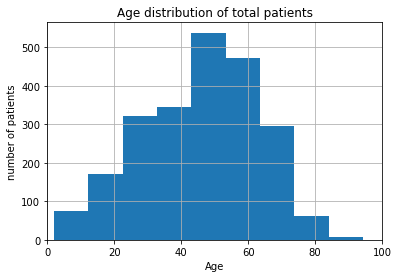

In [14]:
plt.hist(train_data['Patient Age'],bins=40)
plt.grid('on')
plt.xlim([0,100])
plt.xlabel('Age')
plt.ylabel('number of patients')
plt.title('Age distribution of total patients')

In [15]:
train_data['Patient Gender'].value_counts()/len(train_data)

M    0.582533
F    0.417467
Name: Patient Gender, dtype: float64

train_data.to_csv('train_data.csv')


train_data.head()

for img_name,dii in zip(train_data['Image Index'], train_data['path']):
    file_name='train/' + img_name
    img=Image.open(dii)
####    plt.imshow(img,cmap='gray')
    img.save(file_name)

val_data.to_csv('val_data.csv')

for img_name,dii in zip(val_data['Image Index'], val_data['path']):
    file_name='val/' + img_name
    img=Image.open(dii)
####    plt.imshow(img,cmap='gray')
    img.save(file_name)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [8]:
def my_image_augmentation(rescale,hf=False,vf=False,hs=0.0,ws=0.0,rr=0.0,sr=0.0,zr=0.0):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale=rescale, ##1./255.0,
                               horizontal_flip=hf, #True,
                               vertical_flip=vf, #False,
                               height_shift_range=hs, #0.1,
                               width_shift_range=ws, #0.1,
                               rotation_range=rr, #20,
                               shear_range=sr, #0.1,
                               zoom_range=zr) #0.1)
    
    return my_idg


def make_train_gen(my_train_idg, train_df, IMG_size, batch):
    
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size =IMG_size, 
                                          batch_size = batch)
    return train_gen


def make_val_gen(my_val_idg, val_df, IMG_size, batch):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = IMG_size, 
                                              batch_size = batch) 
    
    
    return val_gen

In [9]:
IMG_size = (224,224)

In [10]:
train_idg = my_image_augmentation(rescale = 1./255.,hf=True,vf=False,hs=0.1,ws=0.1,rr=20,sr=0.1,zr=0.1)
train_gen = make_train_gen(train_idg, train_data, IMG_size, batch=32)

val_idg = my_image_augmentation(rescale = 1./255.,hf=False,vf=False,hs=0.0,ws=0.0,rr=0.0,sr=0.0,zr=0.0)
val_gen = make_val_gen(val_idg, val_data, IMG_size, batch=32)

## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


32


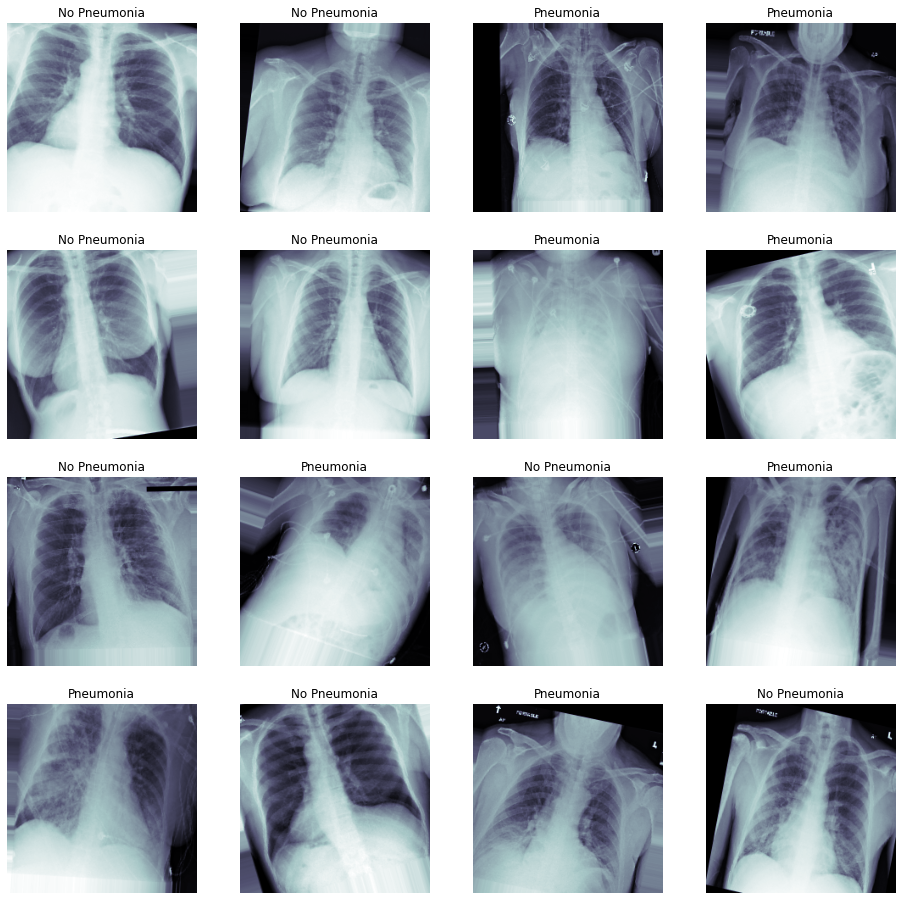

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
print(len(t_x))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [12]:
#def load_pretrained_model(vargs):
    
model = VGG16(include_top=True, weights='imagenet')
model.summary()     
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
#    return vgg_model


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)

In [14]:
def build_my_model(vgg_model):
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable=False
        
    my_model = Sequential()
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    # also make sure you set your optimizer, loss function, and metrics to monitor
    my_model.add(vgg_model)
    
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(1024,activation='relu'))
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(512,activation='relu'))
    my_model.add(Dropout(0.5))   
    
    my_model.add(Dense(256,activation='relu'))
    my_model.add(Dense(1,activation='sigmoid'))
    
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [15]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
#                             monitor= "val_binary_accuracy", 
                             monitor = "val_loss",
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", ##"val_binary_accuracy",  
                      mode= 'min', ##'max', 
                      patience=30)

callbacks_list = [checkpoint, early]

### Start training! 

In [15]:
## train your model

# Todo
my_model=build_my_model(vgg_model)
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs =100, 
                          callbacks = callbacks_list)

Epoch 1/100
72/72 [==============================] - 68s 947ms/step - loss: 0.7825 - binary_accuracy: 0.5170 - val_loss: 0.6711 - val_binary_accuracy: 0.4688

Epoch 00001: val_loss improved from inf to 0.67106, saving model to xray_class_my_model.best.hdf5
Epoch 2/100
72/72 [==============================] - 60s 837ms/step - loss: 0.7134 - binary_accuracy: 0.5415 - val_loss: 0.6463 - val_binary_accuracy: 0.6250

Epoch 00002: val_loss improved from 0.67106 to 0.64628, saving model to xray_class_my_model.best.hdf5
Epoch 3/100
72/72 [==============================] - 62s 854ms/step - loss: 0.6978 - binary_accuracy: 0.5507 - val_loss: 0.8168 - val_binary_accuracy: 0.2812

Epoch 00003: val_loss did not improve from 0.64628
Epoch 4/100
72/72 [==============================] - 61s 840ms/step - loss: 0.6907 - binary_accuracy: 0.5611 - val_loss: 0.7015 - val_binary_accuracy: 0.5938

Epoch 00004: val_loss did not improve from 0.64628
Epoch 5/100
72/72 [==============================] - 60s 828ms

72/72 [==============================] - 57s 794ms/step - loss: 0.5637 - binary_accuracy: 0.7074 - val_loss: 0.4397 - val_binary_accuracy: 0.8125

Epoch 00038: val_loss improved from 0.46702 to 0.43970, saving model to xray_class_my_model.best.hdf5
Epoch 39/100
72/72 [==============================] - 57s 791ms/step - loss: 0.5698 - binary_accuracy: 0.7009 - val_loss: 0.6145 - val_binary_accuracy: 0.6562

Epoch 00039: val_loss did not improve from 0.43970
Epoch 40/100
72/72 [==============================] - 58s 800ms/step - loss: 0.5645 - binary_accuracy: 0.7100 - val_loss: 0.5692 - val_binary_accuracy: 0.7188

Epoch 00040: val_loss did not improve from 0.43970
Epoch 41/100
72/72 [==============================] - 57s 797ms/step - loss: 0.5548 - binary_accuracy: 0.7179 - val_loss: 0.6221 - val_binary_accuracy: 0.6875

Epoch 00041: val_loss did not improve from 0.43970
Epoch 42/100
72/72 [==============================] - 57s 796ms/step - loss: 0.5542 - binary_accuracy: 0.7166 - val_lo

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [16]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model=build_my_model(vgg_model)
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

32/32 [==============================] - 4s 128ms/step


In [17]:
pred_Y

array([[0.2313991 ],
       [0.23841798],
       [0.27388436],
       [0.13996126],
       [0.5538467 ],
       [0.6666432 ],
       [0.31592858],
       [0.07683036],
       [0.01154699],
       [0.6449838 ],
       [0.12589633],
       [0.22316638],
       [0.32152066],
       [0.12714382],
       [0.31485856],
       [0.09733919],
       [0.45147327],
       [0.23952247],
       [0.502202  ],
       [0.52238864],
       [0.21079332],
       [0.16353191],
       [0.22441848],
       [0.09732   ],
       [0.11998714],
       [0.08819952],
       [0.01590174],
       [0.40985495],
       [0.59288776],
       [0.02407026],
       [0.3974613 ],
       [0.13857865]], dtype=float32)

In [30]:
# evaluate model
_, acc = my_model.evaluate_generator(val_gen, steps=len(val_gen), verbose=0)
print('Test Accuracy: %.3f' % (acc * 100))

Test Accuracy: 71.608


In [31]:
def plot_auc(t_y, p_y):
    
    fig,ax = plt.subplots(1,1,figsize=(9,9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    ax.legend()
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
     
    return

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

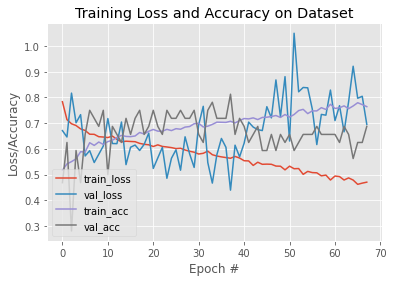

In [32]:
## plot figures

plot_history(history)

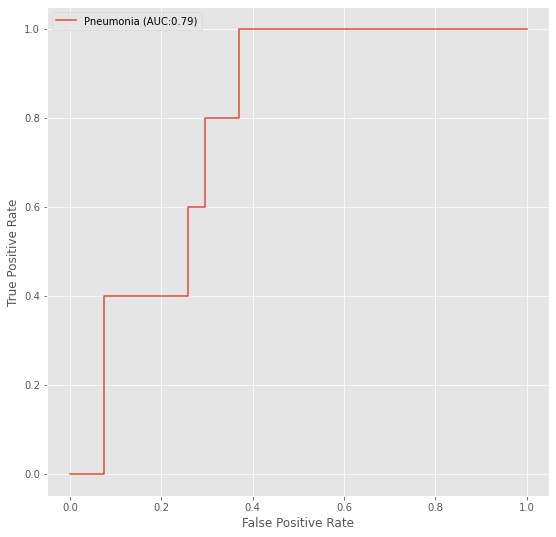

In [33]:
plot_auc(valY,pred_Y)

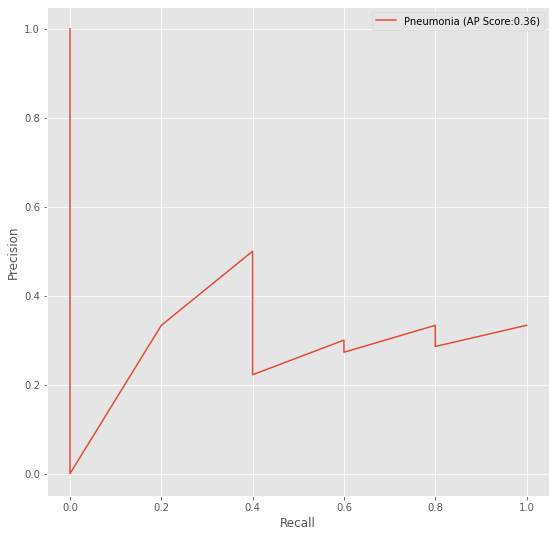

In [34]:
plot_precision_recall_curve(valY,pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [35]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY,pred_Y)

In [45]:
for id in range(len(precision)-2):
    print(f'p={precision[id]},r={recall[id]},thresh={thresholds[id]},F1 Score is: ' + str(calc_f1(precision[id],recall[id])))

p=0.3333333333333333,r=1.0,thresh=0.2703797519207001,F1 Score is: 0.5
p=0.2857142857142857,r=0.8,thresh=0.27056464552879333,F1 Score is: 0.4210526315789473
p=0.3076923076923077,r=0.8,thresh=0.2988918423652649,F1 Score is: 0.4444444444444444
p=0.3333333333333333,r=0.8,thresh=0.3798384666442871,F1 Score is: 0.47058823529411764
p=0.2727272727272727,r=0.6,thresh=0.39730408787727356,F1 Score is: 0.37499999999999994
p=0.3,r=0.6,thresh=0.40074655413627625,F1 Score is: 0.4
p=0.2222222222222222,r=0.4,thresh=0.45099499821662903,F1 Score is: 0.2857142857142857
p=0.25,r=0.4,thresh=0.4525424838066101,F1 Score is: 0.3076923076923077
p=0.2857142857142857,r=0.4,thresh=0.4547399580478668,F1 Score is: 0.3333333333333333
p=0.3333333333333333,r=0.4,thresh=0.4979177713394165,F1 Score is: 0.3636363636363636
p=0.4,r=0.4,thresh=0.5101757645606995,F1 Score is: 0.4000000000000001
p=0.5,r=0.4,thresh=0.5484725832939148,F1 Score is: 0.4444444444444445
p=0.3333333333333333,r=0.2,thresh=0.5651216506958008,F1 Score i

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


In [37]:
# Look at the threshold where precision is 0.55
precision_value = 0.33
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.3333333333333333
Recall is: 1.0
Threshold is: 0.27037975
F1 Score is: 0.5


In [38]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.2857142857142857
Recall is: 0.8
Threshold is: 0.27056465
F1 Score is: 0.4210526315789473


In [51]:
#tmp=pd.DataFrame(pred_Y)
tmp=pred_Y
t1=(tmp>0.27)
#t1 = t1.replace(True,1).replace(False,0)
testy=pred_Y.flatten()
t1=t1.flatten()
compare_t1 = (t1 == valY)
print('Accuracy at threshold: ' + str(len(compare_t1[compare_t1])/len(valY)))

Accuracy at threshold: 0.6875


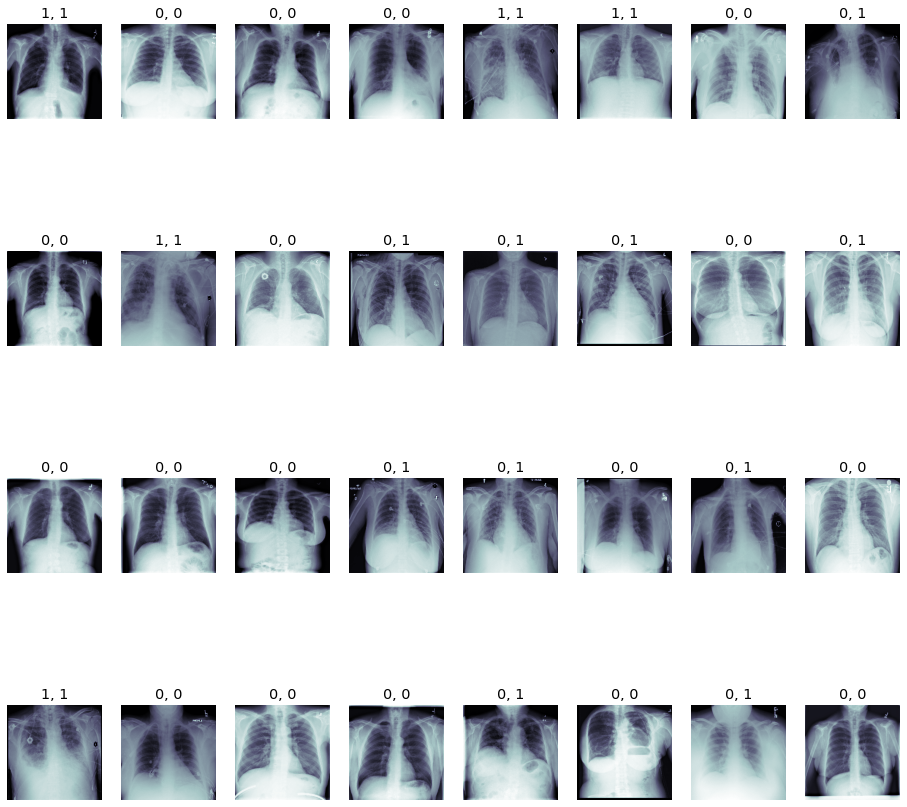

In [52]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(4, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:32], valY[0:32], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.27:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 0.27: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [53]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)